**Submission Instruction**


1 - Save a copy of the notebook and replace blank with your name

2- Complete all of the cells according to the instructions

3- Run all cells

4- Download .ipynb and submit on Gradescope

# Airflow + YFinance: News & Price Event-Study Pipeline

In the previous notebook you learned the **core ideas of Airflow** using a small word-count DAG:  
you saw how a DAG is a **Directed Acyclic Graph of tasks**, how tasks depend on each other, and how to run them step-by-step with `airflow tasks test`.

In this notebook we’ll reuse those ideas in a **more realistic data engineering scenario** built around financial data:

- Use `yfinance` to **fetch recent news** for a few tickers (e.g. AAPL, MSFT, TSLA).
- **Normalize** the raw news JSON into a clean tabular format.
- Fetch **historical price data** for the same tickers.
- Run a simple **event-study style analysis**, looking at how prices move around the time of news.
- Save intermediate outputs (CSV / SQL) so you can query and inspect the data.

You will:

1. Read and understand helper functions that do the actual work (fetching news, cleaning it, fetching prices, running the analysis).
2. **Define the Airflow DAG yourself** (DAG id, tasks, dependencies) using `PythonOperator`, based on what you learned in the intro notebook.
3. Run each task with `airflow tasks test` and inspect the intermediate files/tables to see how the pipeline behaves.

Think of this notebook as the bridge from *toy* DAGs to a **real data engineering pipeline**: same concepts (DAG, tasks, dependencies), but now applied to an end-to-end workflow that touches external APIs, storage, and analysis.


In [ ]:
# Install Airflow, yfinance, and plotting / DB helpers
# This can take a few minutes. Again igore errors regarding google-adk
!pip install -q apache-airflow==2.10.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 633.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.3/591.3 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.

In [ ]:
#Check airflow version. If you see the version 2.10.1 it means that installation was successful.
!airflow version

2.10.1


In [ ]:
import os
from pathlib import Path

# Set AIRFLOW_HOME inside the Colab filesystem
os.environ["AIRFLOW_HOME"] = "/content/airflow"
os.environ["AIRFLOW__CORE__LOAD_EXAMPLES"] = "False"

airflow_home = Path(os.environ["AIRFLOW_HOME"])
airflow_home.mkdir(parents=True, exist_ok=True)

dags_dir = airflow_home / "dags"
dags_dir.mkdir(parents=True, exist_ok=True)

data_dir = airflow_home / "data"
data_dir.mkdir(parents=True, exist_ok=True)

print("AIRFLOW_HOME:", airflow_home)
print("DAGs dir    :", dags_dir)
print("Data dir    :", data_dir)

AIRFLOW_HOME: /content/airflow
DAGs dir    : /content/airflow/dags
Data dir    : /content/airflow/data


In [ ]:
# OPTIONAL: aggressively remove example DAGs that may still be shipped in the package
# Removing example dags reduces the info logs and warnings later.

!rm -rf /usr/local/lib/python3.12/dist-packages/airflow/example_dags


## Initialize Airflow metadata DB

This sets up Airflow's metadata database in the Colab environment

In [ ]:
# Initialize the Airflow metadatabase
!airflow db init


DB: sqlite:////content/airflow/airflow.db
[2025-12-05T18:59:54.633+0000] {migration.py:211} INFO - Context impl SQLiteImpl.
[2025-12-05T18:59:54.638+0000] {migration.py:214} INFO - Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running stamp_revision  -> 22ed7efa9da2
WARNI [airflow.models.crypto] empty cryptography key - values will not be stored encrypted.
Initialization done


## Helper module 1: News ETL with yfinance

This module:

- Fetches raw news for a list of tickers using `yfinance`.
- Normalizes and deduplicates the news.
- Aggregates per-day, per-ticker article counts into a CSV (`news_digest.csv`).

These functions will be used inside your Airflow DAG via `PythonOperator` tasks.

In [ ]:
%%writefile /content/airflow/dags/news_etl_helpers.py
from pathlib import Path
from datetime import datetime, timezone

import pandas as pd
import yfinance as yf

# All data stored under AIRFLOW_HOME/data
DATA_DIR = Path("/content/airflow/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

TICKERS = ["AAPL", "MSFT", "TSLA"]

RAW_PATH = DATA_DIR / "news_raw.csv"
NORM_PATH = DATA_DIR / "news_normalized.csv"
DIGEST_PATH = DATA_DIR / "news_digest.csv"


def fetch_news_raw(**context):
    """
    Fetch raw news for all tickers via yfinance.Ticker.get_news()
    and dump a flattened version to CSV.
    """
    all_rows = []
    now = datetime.now(timezone.utc)

    for t in TICKERS:
        ticker = yf.Ticker(t)
        # Newer API: get_news()
        news_items = ticker.get_news() or []
        print(f"{t}: get_news() returned {len(news_items)} items")

        for item in news_items:
            c = item.get("content", {}) or {}

            title = c.get("title")
            summary = c.get("summary") or c.get("description")
            provider = (c.get("provider") or {}).get("displayName")

            # Prefer canonical URL, fall back to clickThroughUrl
            canonical = (c.get("canonicalUrl") or {}).get("url")
            clickthrough = (c.get("clickThroughUrl") or {}).get("url")
            link = canonical or clickthrough

            pub_iso = c.get("pubDate")  # e.g. '2025-11-29T11:00:14Z'

            # Skip totally empty rows
            if not title and not link and not summary:
                continue

            all_rows.append({
                "ticker": t,
                "title": title,
                "summary": summary,
                "publisher": provider,
                "link": link,
                "pubDate": pub_iso,
                "fetched_at": now.isoformat(),
            })

    if not all_rows:
        print("No usable news found – writing empty CSV.")
        pd.DataFrame(columns=[
            "ticker", "title", "summary", "publisher", "link", "pubDate", "fetched_at"
        ]).to_csv(RAW_PATH, index=False)
        return

    df = pd.DataFrame(all_rows)
    df.to_csv(RAW_PATH, index=False)
    print(f"Fetched {len(df)} usable news rows to {RAW_PATH}")
    print("Columns:", df.columns.tolist())
    print(df.head())


def normalize_news(**context):
    """
    Clean up news data: basic filtering, timestamp parsing, dedup.

    - Uses 'pubDate' (ISO string) as the main time field.
    - Derives a 'date' column from published_dt.
    """
    df = pd.read_csv(RAW_PATH)
    print("Raw rows:", len(df))
    print("Raw columns:", df.columns.tolist())

    if df.empty:
        print("Raw news file is empty; writing empty normalized file.")
        df.to_csv(NORM_PATH, index=False)
        return

    # Keep only rows with a title
    if "title" in df.columns:
        df = df.dropna(subset=["title"])
    else:
        print("WARNING: 'title' column missing in raw data")

    # Parse pubDate (ISO string) into datetime
    if "pubDate" in df.columns:
        df["published_dt"] = pd.to_datetime(df["pubDate"], errors="coerce", utc=True)
        df["date"] = df["published_dt"].dt.date
    else:
        print("WARNING: 'pubDate' missing; using fetched_at instead if available.")
        if "fetched_at" in df.columns:
            df["published_dt"] = pd.to_datetime(df["fetched_at"], errors="coerce", utc=True)
            df["date"] = df["published_dt"].dt.date
        else:
            df["published_dt"] = pd.NaT
            df["date"] = pd.NaT

    # Deduplicate on ticker + title + link
    subset_cols = [c for c in ["ticker", "title", "link"] if c in df.columns]
    if subset_cols:
        df = df.drop_duplicates(subset=subset_cols)

    print("Normalized rows after cleaning:", len(df))
    df.to_csv(NORM_PATH, index=False)
    print(f"Normalized news saved to {NORM_PATH}")


def aggregate_daily_digest(**context):
    """Aggregate article counts per date per ticker."""
    df = pd.read_csv(NORM_PATH)
    if df.empty:
        print("No news to aggregate (normalized file is empty).")
        pd.DataFrame(columns=["date", "ticker", "article_count"]).to_csv(DIGEST_PATH, index=False)
        return

    agg = (
        df.groupby(["date", "ticker"])
          .size()
          .reset_index(name="article_count")
          .sort_values(["date", "ticker"])
    )

    agg.to_csv(DIGEST_PATH, index=False)
    print(f"Digest saved to {DIGEST_PATH}")


Writing /content/airflow/dags/news_etl_helpers.py


## Helper module 2: SQLite storage, price snapshots, analytics & chart

This module:

- Loads the news digest into a SQLite DB (`market.db`).
- Fetches **price snapshots** for the same tickers and stores them in SQLite.
- Runs an analytics SQL query joining news + prices.
- Computes a simple correlation between news volume and price moves.
- Generates a chart overlaying price and news article counts for one ticker.

### A quick note on SQLite (vs. MySQL)

In this notebook we’ll use **SQLite** as our database instead of MySQL.

- **SQLite is an embedded SQL database**: it doesn’t run as a separate server.  
  Everything lives in a single file on disk (e.g. `news_prices.db`), and your Python code reads/writes directly to that file.

- **Same SQL, lighter setup**:  
  You still use tables, `SELECT`, `JOIN`, `GROUP BY`, etc., just like in MySQL.  
  The big difference is there is **no network connection, no username/password, no server process** to start. That makes it very convenient for demos, local scripts, and small data engineering pipelines.

- **How we’ll use it here**:  
  We’ll let Airflow tasks:
  - create a SQLite database file,
  - insert news and price data into tables,
  - run queries to join and analyze them.

You can think of SQLite as “**MySQL in a single file**,” perfect for Colab and for learning how to connect Airflow tasks to a database without extra infrastructure.


In [ ]:
%%writefile /content/airflow/dags/news_price_helpers.py
from pathlib import Path
from datetime import datetime, timezone
import sqlite3

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

DATA_DIR = Path("/content/airflow/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

DB_PATH = DATA_DIR / "market.db"
NEWS_NORMALIZED_CSV = DATA_DIR / "news_normalized.csv"

TICKERS = ["AAPL", "MSFT", "TSLA"]


def _get_conn():
    return sqlite3.connect(DB_PATH)

def load_news_to_sqlite(**context):
    """
    Load news_normalized.csv into SQLite table `news_events`.

    Expects columns like:
      - ticker
      - title
      - summary
      - publisher
      - link
      - pubDate
      - fetched_at
      - published_dt
      - date
    """
    run_ts = datetime.now(timezone.utc).isoformat()

    df = pd.read_csv(NEWS_NORMALIZED_CSV)
    if df.empty:
        print("Normalized news file is empty; nothing to load.")
        return

    # Ensure published_dt is parsed and stored as ISO string
    if "published_dt" in df.columns:
        df["published_dt"] = pd.to_datetime(df["published_dt"], errors="coerce", utc=True)
    elif "pubDate" in df.columns:
        df["published_dt"] = pd.to_datetime(df["pubDate"], errors="coerce", utc=True)
    else:
        df["published_dt"] = pd.to_datetime(df["fetched_at"], errors="coerce", utc=True)

    df["published_dt"] = df["published_dt"].dt.strftime("%Y-%m-%d %H:%M:%S%z")
    df["run_ts"] = run_ts

    with _get_conn() as conn:
        #df.to_sql is a Pandas helper that takes a DataFrame and writes it into a SQL table.
        df.to_sql("news_events", conn, if_exists="append", index=False)

    print(f"Inserted {len(df)} news events into SQLite at {run_ts}")


def fetch_price_history(**context):
    """
    Fetch historical OHLCV for each ticker separately and store in
    a normalized SQLite table `price_history`:

        ticker | ts | Open | High | Low | Close | Volume
    """
    all_rows = []

    for t in TICKERS:
        print(f"Downloading history for {t}...")
        symbol_data = yf.Ticker(t)
        hist = symbol_data.history(
            period="5d",
            interval="30m",
        )

        if hist.empty:
            print(f"No historical data for {t}")
            continue

        hist = hist.reset_index()

        # yfinance uses 'Datetime' for intraday intervals, 'Date' for daily
        if "Datetime" in hist.columns:
            hist = hist.rename(columns={"Datetime": "ts"})
        elif "Date" in hist.columns:
            hist = hist.rename(columns={"Date": "ts"})
        else:
            raise ValueError(f"Could not find time column in history for {t}: {hist.columns}")

        hist["ticker"] = t

        df_t = hist[["ticker", "ts", "Open", "High", "Low", "Close", "Volume"]].copy()
        df_t["ts"] = pd.to_datetime(df_t["ts"], utc=True)
        all_rows.append(df_t)

    if not all_rows:
        print("No price data fetched for any ticker.")
        return

    df_all = pd.concat(all_rows, ignore_index=True)

    with _get_conn() as conn:
        # Replace the old wide MultiIndex-style table
        df_all.to_sql("price_history", conn, if_exists="replace", index=False)

    print("price_history schema reset to normalized format:")
    print(df_all.head())

def run_news_price_event_study(window_hours: int = 1, **context):
    """
    For each news event in `news_events`, find:
      - price_before: last price at or before published_dt
      - price_after: first price at or after published_dt + window_hours

    Then compute a simple return between those two times.
    """
    with _get_conn() as conn:
        # Load news and prices into pandas for easier manipulation
        #`read_sql_query` runs a SQL SELECT query on a database and returns the result as a Pandas DataFrame.
        #It is a simpler form of what we have done earlier using conn and Dataframe wrapper

        news = pd.read_sql_query("SELECT * FROM news_events", conn, parse_dates=["published_dt"])
        prices = pd.read_sql_query("SELECT * FROM price_history", conn, parse_dates=["ts"])

    if news.empty:
        print("No news_events in DB yet.")
        return
    if prices.empty:
        print("No price_history in DB yet.")
        return

    # Sort for as-of merges
    news = news.sort_values(["ticker", "published_dt"])
    prices = prices.sort_values(["ticker", "ts"])

    results = []

    for t in news["ticker"].unique():
        n_t = news[news["ticker"] == t].copy()
        p_t = prices[prices["ticker"] == t].copy()

        if p_t.empty:
            continue

        # Price before: merge_asof (last price at or before news time)
        # So far you’ve seen `pd.merge`, which works like a normal SQL **JOIN**:
        # it matches rows when the key columns are exactly equal
        # (e.g., same `ticker` AND same `date`).
        # For time series, we often want something softer like:
        # “For each news item, find the closest price before (or after) it.”
        # This is what `pd.merge_asof` is for.
        #To join to the nearest key on a sorted column (usually time)

        before = pd.merge_asof(
            n_t.sort_values("published_dt"),
            p_t.sort_values("ts")[["ts", "Close"]],
            left_on="published_dt",
            right_on="ts",
            direction="backward",
        )
        before = before.rename(columns={"ts": "ts_before", "Close": "price_before"})

        # Price after: shift news time by window_hours, then merge_asof forward
        after_time = before["published_dt"] + pd.to_timedelta(window_hours, unit="h")
        after = pd.merge_asof(
            before.sort_values("published_dt"),
            p_t.sort_values("ts")[["ts", "Close"]],
            left_on=after_time,
            right_on="ts",
            direction="forward",
        )
        after = after.rename(columns={"ts": "ts_after", "Close": "price_after"})

        # Compute simple return
        after["return_window"] = (after["price_after"] - after["price_before"]) / after["price_before"]
        results.append(after)

    if not results:
        print("No joinable news/price data.")
        return

    df_res = pd.concat(results, ignore_index=True)

    # Show a small sample
    cols = [
        "ticker",
        "published_dt",
        "title",
        "price_before",
        "ts_before",
        "price_after",
        "ts_after",
        "return_window",
    ]
    cols = [c for c in cols if c in df_res.columns]

    print(f"=== Event-study returns over {window_hours}h window ===")
    print(df_res[cols].sort_values("published_dt", ascending=False).head(20).to_string(index=False))


def generate_price_news_chart(
    ticker: str = "AAPL",
    lookback_days: int = 3,
    **context,
):
    """
    Plot Close price from price_history and overlay number of news events per bar time.
    """
    with _get_conn() as conn:
        prices = pd.read_sql_query(
            "SELECT * FROM price_history WHERE ticker = ?",
            conn,
            params=[ticker],
            parse_dates=["ts"],
        )
        news = pd.read_sql_query(
            "SELECT * FROM news_events WHERE ticker = ?",
            conn,
            params=[ticker],
            parse_dates=["published_dt"],
        )

    if prices.empty:
        print(f"No prices for {ticker}")
        return

    # Limit to recent window
    cutoff = prices["ts"].max() - pd.Timedelta(days=lookback_days)
    prices = prices[prices["ts"] >= cutoff]

    # Aggregate news counts per bar period (nearest bar or floor to 30min)
    # Simple approach: round published_dt to 30-minute buckets
    news = news.copy()
    news["bucket"] = news["published_dt"].dt.floor("30min")
    news_counts = (
        news.groupby("bucket")
            .size()
            .reset_index(name="article_count")
            .rename(columns={"bucket": "ts"})
    )

    # Merge for plotting
    merged = pd.merge(
        prices[["ts", "Close"]],
        news_counts,
        on="ts",
        how="left",
    ).fillna({"article_count": 0})

    fig, ax_price = plt.subplots(figsize=(10, 4))

    ax_price.plot(merged["ts"], merged["Close"], marker="o")
    ax_price.set_xlabel("Time")
    ax_price.set_ylabel("Close price")

    ax_news = ax_price.twinx()
    ax_news.bar(merged["ts"], merged["article_count"], alpha=0.3)
    ax_news.set_ylabel("# news articles (per 30m)")

    plt.title(f"{ticker}: Close vs news volume (last {lookback_days} days)")
    fig.autofmt_xdate()
    out_path = DATA_DIR / f"{ticker}_price_news.png"
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close(fig)

    print(f"Saved chart to {out_path}")


Writing /content/airflow/dags/news_price_helpers.py


## TODO: Define the Airflow DAG for the YFinance News–Price Pipeline (10 points)

In this cell you will **define the Airflow DAG** that orchestrates the steps of our
news–price event study.

You should:

1. Create a `DAG` with:
   - `dag_id="yfinance_news_price_pipeline"`
   - a reasonable `start_date` (e.g. `datetime(2025, 12, 1)`)
   - `schedule_interval=None` (manual runs in Colab) **or** a cron like `"*/10 * * * *"` for every 10 minutes.
   - `catchup=False`.

2. Create **one `PythonOperator` per step** using the helper functions from
   `news_price_helpers.py`:
   - `fetch_news_raw` – fetch raw news from yfinance and save to CSV.
   - `normalize_news` – clean/normalize the raw news into a tabular CSV.
   - `fetch_price_history` – fetch historical price data and store it (e.g. in SQLite).
   - `run_news_price_event_study` – join news with prices and generate the analysis/plot.

3. Give each task a clear `task_id`, for example:
   - `"fetch_news_raw"`, `"normalize_news"`, `"fetch_price_history"`, `"run_news_price_event_study"`.

4. Wire the task **dependencies** to reflect the logical flow, for example:

```text
fetch_news_raw -> normalize_news -> fetch_price_history -> run_news_price_event_study


In [26]:
%%writefile /content/airflow/dags/yfinance_news_price_dag.py

from datetime import datetime, timedelta

from airflow import DAG
from airflow.operators.python import PythonOperator

from news_etl_helpers import (
    fetch_news_raw,
    normalize_news,
    aggregate_daily_digest,
)
from news_price_helpers import (
    load_news_to_sqlite,
    fetch_price_history,
    run_news_price_event_study,
    generate_price_news_chart,
)


default_args = {
    "owner": "student",
    "retries": 1,
    "retry_delay": timedelta(minutes=5),
}

with DAG(
    dag_id="yfinance_news_price_pipeline",
    default_args=default_args,
    start_date=datetime(2025, 12, 1),
    schedule_interval=None,
    catchup=False,
    description="YFinance News–Price Event Study Pipeline",
) as dag:

    task_fetch_news_raw = PythonOperator(
        task_id="fetch_news_raw",
        python_callable=fetch_news_raw,
    )

    task_normalize_news = PythonOperator(
        task_id="normalize_news",
        python_callable=normalize_news,
    )

    task_aggregate_daily_digest = PythonOperator(
        task_id="aggregate_daily_digest",
        python_callable=aggregate_daily_digest,
    )

    task_load_news_to_sqlite = PythonOperator(
        task_id="load_news_to_sqlite",
        python_callable=load_news_to_sqlite,
    )

    task_fetch_price_history = PythonOperator(
        task_id="fetch_price_history",
        python_callable=fetch_price_history,
    )

    task_run_event_study = PythonOperator(
        task_id="run_news_price_event_study",
        python_callable=run_news_price_event_study,
        op_kwargs={"window_hours": 1},
    )

    task_generate_chart = PythonOperator(
        task_id="generate_price_news_chart",
        python_callable=generate_price_news_chart,
        op_kwargs={"ticker": "AAPL", "lookback_days": 3},
    )

    task_fetch_news_raw >> task_normalize_news >> task_aggregate_daily_digest >> task_load_news_to_sqlite


    [task_load_news_to_sqlite, task_fetch_price_history] >> task_run_event_study >> task_generate_chart

Overwriting /content/airflow/dags/yfinance_news_price_dag.py


## Testing tasks from Colab (no scheduler needed)

In a proper Airflow deployment, the **scheduler** will run this DAG automatically every 10 minutes.

In Colab, it's often easier to **test individual tasks** with `airflow tasks test` or `airflow tasks run`,
instead of trying to run a long-lived scheduler.

The cell below shows how to:

- List DAGs.
- Test one of the tasks in the DAG on a dummy execution date.


In [12]:
# List all known DAGs
!airflow dags list | head

!airflow tasks list yfinance_news_price_pipeline --tree

# !airflow dags list-import-errors




dag_id                       | fileloc                                          | owners  | is_paused
=============================+==================================================+=========+==========
yfinance_news_price_pipeline | /content/airflow/dags/yfinance_news_price_dag.py | student | None     
                                                                                                     
<Task(PythonOperator): fetch_news_raw>
    <Task(PythonOperator): normalize_news>
        <Task(PythonOperator): aggregate_daily_digest>
            <Task(PythonOperator): load_news_to_sqlite>
                <Task(PythonOperator): run_news_price_event_study>
<Task(PythonOperator): fetch_price_history>
    <Task(PythonOperator): run_news_price_event_study>


In [13]:
# Test a single task (e.g., fetch_news_raw) for a dummy execution date
# This will run it immediately in this Colab environment.
!airflow tasks test yfinance_news_price_pipeline fetch_news_raw 2025-12-01

# After this succeeds, you can test downstream tasks similarly, or run the whole DAG
# for a specific execution date using `airflow dags test`


[2025-12-05T19:05:23.736+0000] {dagbag.py:587} INFO - Filling up the DagBag from /content/airflow/dags
[2025-12-05T19:05:24.027+0000] {utils.py:164} INFO - NumExpr defaulting to 2 threads.
[2025-12-05T19:05:25.296+0000] {taskinstance.py:2612} INFO - Dependencies all met for dep_context=non-requeueable deps ti=<TaskInstance: yfinance_news_price_pipeline.fetch_news_raw __airflow_temporary_run_2025-12-05T19:05:25.258253+00:00__ [None]>
[2025-12-05T19:05:25.304+0000] {taskinstance.py:2612} INFO - Dependencies all met for dep_context=requeueable deps ti=<TaskInstance: yfinance_news_price_pipeline.fetch_news_raw __airflow_temporary_run_2025-12-05T19:05:25.258253+00:00__ [None]>
[2025-12-05T19:05:25.304+0000] {taskinstance.py:2865} INFO - Starting attempt 0 of 2
[2025-12-05T19:05:25.305+0000] {taskinstance.py:2946} WARNING - cannot record queued_duration for task fetch_news_raw because previous state change time has not been saved
[2025-12-05T19:05:25.306+0000] {taskinstance.py:2888} INFO - E

In [14]:
#let's inspect the output of task one:
import pandas as pd
from pathlib import Path

data_dir = Path("/content/airflow/data")
print("Files in data dir:")
print(list(data_dir.iterdir()))

# TODO: replace this with your actual raw-news file name
raw_path = data_dir / "news_raw.csv"

raw_news = pd.read_csv(raw_path)  # or read_json, depending on your format
print("=== raw news head ===")
print(raw_news.head())

print("\n=== raw news info ===")
print(raw_news.info())

print("\nRows per ticker:")
print(raw_news["ticker"].value_counts())

Files in data dir:
[PosixPath('/content/airflow/data/news_raw.csv')]
=== raw news head ===
  ticker                                              title  \
0   AAPL  Netflix to acquire Warner Bros., more executiv...   
1   AAPL  Meta stock climbs on report company will make ...   
2   AAPL  BTIG thinks Apple stock is poised to drop, Pep...   
3   AAPL  eSIM adoption is on the rise thanks to travel ...   
4   AAPL  Meet the Supercharged Growth Stock That Could ...   

                                             summary            publisher  \
0  Morning Brief anchor Julie Hyman breaks down t...  Yahoo Finance Video   
1  Meta is reportedly looking to cut back on its ...        Yahoo Finance   
2  Market Domination host Josh Lipton and Yahoo F...  Yahoo Finance Video   
3  As a technology, eSIM has been around for a de...           TechCrunch   
4  Eli Lilly's stock price and market cap are poi...          Motley Fool   

                                                link               

## TODO - 20 Points
For the rest of the notebook, run each task in one cell, followed by another cell containing a simple inspection. The goal of inspection cell is to make sure that the task didn't fail and you understand the output structure of the task. For SQL part you can simply use SELECT *
Below is an example.

In [ ]:
import pandas as pd
import sqlite3
from pathlib import Path

data_dir = Path("/content/airflow/data")

# TODO: replace with your actual DB file name
db_path = data_dir / "news_prices.db"
print("DB exists:", db_path.exists(), "->", db_path)

conn = sqlite3.connect(db_path)

# TODO: replace 'prices' with your actual table name and replace columns with your actual column names
df_prices_sample = pd.read_sql_query(
    """
    SELECT *
    FROM prices
    ORDER BY ts
    LIMIT 10;
    """,
    con=conn
)

print("=== sample prices ===")
print(df_prices_sample)

In [28]:
#Next task
!airflow tasks test yfinance_news_price_pipeline normalize_news 2025-12-01







[2025-12-05T19:12:06.278+0000] {dagbag.py:587} INFO - Filling up the DagBag from /content/airflow/dags
[2025-12-05T19:12:06.892+0000] {utils.py:164} INFO - NumExpr defaulting to 2 threads.
[2025-12-05T19:12:09.339+0000] {taskinstance.py:2612} INFO - Dependencies all met for dep_context=non-requeueable deps ti=<TaskInstance: yfinance_news_price_pipeline.normalize_news __airflow_temporary_run_2025-12-05T19:12:09.297480+00:00__ [None]>
[2025-12-05T19:12:09.347+0000] {taskinstance.py:2612} INFO - Dependencies all met for dep_context=requeueable deps ti=<TaskInstance: yfinance_news_price_pipeline.normalize_news __airflow_temporary_run_2025-12-05T19:12:09.297480+00:00__ [None]>
[2025-12-05T19:12:09.348+0000] {taskinstance.py:2865} INFO - Starting attempt 0 of 2
[2025-12-05T19:12:09.348+0000] {taskinstance.py:2946} WARNING - cannot record queued_duration for task normalize_news because previous state change time has not been saved
[2025-12-05T19:12:09.349+0000] {taskinstance.py:2888} INFO - E

In [29]:
#task inspection
import pandas as pd
from pathlib import Path

data_dir = Path("/content/airflow/data")
norm_path = data_dir / "news_normalized.csv"

print("File exists:", norm_path.exists(), "->", norm_path)
df = pd.read_csv(norm_path)
print("=== normalized head ===")
print(df.head())
print("\nShape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nRows per ticker:")
print(df["ticker"].value_counts(dropna=False))


File exists: True -> /content/airflow/data/news_normalized.csv
=== normalized head ===
  ticker                                              title  \
0   AAPL  Netflix to acquire Warner Bros., more executiv...   
1   AAPL  Meta stock climbs on report company will make ...   
2   AAPL  BTIG thinks Apple stock is poised to drop, Pep...   
3   AAPL  eSIM adoption is on the rise thanks to travel ...   
4   AAPL  Meet the Supercharged Growth Stock That Could ...   

                                             summary            publisher  \
0  Morning Brief anchor Julie Hyman breaks down t...  Yahoo Finance Video   
1  Meta is reportedly looking to cut back on its ...        Yahoo Finance   
2  Market Domination host Josh Lipton and Yahoo F...  Yahoo Finance Video   
3  As a technology, eSIM has been around for a de...           TechCrunch   
4  Eli Lilly's stock price and market cap are poi...          Motley Fool   

                                                link               pubD

In [30]:
#next task
!airflow tasks test yfinance_news_price_pipeline aggregate_daily_digest 2025-12-01


[2025-12-05T19:12:29.881+0000] {dagbag.py:587} INFO - Filling up the DagBag from /content/airflow/dags
[2025-12-05T19:12:30.750+0000] {utils.py:164} INFO - NumExpr defaulting to 2 threads.
[2025-12-05T19:12:32.287+0000] {taskinstance.py:2612} INFO - Dependencies all met for dep_context=non-requeueable deps ti=<TaskInstance: yfinance_news_price_pipeline.aggregate_daily_digest __airflow_temporary_run_2025-12-05T19:12:32.244961+00:00__ [None]>
[2025-12-05T19:12:32.298+0000] {taskinstance.py:2612} INFO - Dependencies all met for dep_context=requeueable deps ti=<TaskInstance: yfinance_news_price_pipeline.aggregate_daily_digest __airflow_temporary_run_2025-12-05T19:12:32.244961+00:00__ [None]>
[2025-12-05T19:12:32.299+0000] {taskinstance.py:2865} INFO - Starting attempt 0 of 2
[2025-12-05T19:12:32.300+0000] {taskinstance.py:2946} WARNING - cannot record queued_duration for task aggregate_daily_digest because previous state change time has not been saved
[2025-12-05T19:12:32.301+0000] {taskin

In [31]:
#inspect
import pandas as pd
from pathlib import Path

data_dir = Path("/content/airflow/data")
digest_path = data_dir / "news_digest.csv"

print("File exists:", digest_path.exists(), "->", digest_path)
df = pd.read_csv(digest_path)
print("=== digest head ===")
print(df.head())
print("\nShape:", df.shape)
print("\nUnique dates:", df["date"].nunique() if "date" in df.columns else "no date col")
print("\nArticle counts sample:")
print(df.sort_values(["date","ticker"]).head(10))


File exists: True -> /content/airflow/data/news_digest.csv
=== digest head ===
         date ticker  article_count
0  2025-12-04   AAPL              2
1  2025-12-04   MSFT              2
2  2025-12-05   AAPL              8
3  2025-12-05   MSFT              8
4  2025-12-05   TSLA             10

Shape: (5, 3)

Unique dates: 2

Article counts sample:
         date ticker  article_count
0  2025-12-04   AAPL              2
1  2025-12-04   MSFT              2
2  2025-12-05   AAPL              8
3  2025-12-05   MSFT              8
4  2025-12-05   TSLA             10


In [32]:
!airflow tasks test yfinance_news_price_pipeline load_news_to_sqlite 2025-12-01


[2025-12-05T19:12:50.834+0000] {dagbag.py:587} INFO - Filling up the DagBag from /content/airflow/dags
[2025-12-05T19:12:51.160+0000] {utils.py:164} INFO - NumExpr defaulting to 2 threads.
[2025-12-05T19:12:52.700+0000] {taskinstance.py:2612} INFO - Dependencies all met for dep_context=non-requeueable deps ti=<TaskInstance: yfinance_news_price_pipeline.load_news_to_sqlite __airflow_temporary_run_2025-12-05T19:12:52.654090+00:00__ [None]>
[2025-12-05T19:12:52.709+0000] {taskinstance.py:2612} INFO - Dependencies all met for dep_context=requeueable deps ti=<TaskInstance: yfinance_news_price_pipeline.load_news_to_sqlite __airflow_temporary_run_2025-12-05T19:12:52.654090+00:00__ [None]>
[2025-12-05T19:12:52.710+0000] {taskinstance.py:2865} INFO - Starting attempt 0 of 2
[2025-12-05T19:12:52.710+0000] {taskinstance.py:2946} WARNING - cannot record queued_duration for task load_news_to_sqlite because previous state change time has not been saved
[2025-12-05T19:12:52.711+0000] {taskinstance.py

In [33]:
# inspect
import sqlite3
import pandas as pd
from pathlib import Path

db_path = Path("/content/airflow/data/market.db")
print("DB exists:", db_path.exists(), "->", db_path)

conn = sqlite3.connect(db_path)
df_sample = pd.read_sql_query("""
SELECT ticker, title, published_dt, date, run_ts
FROM news_events
ORDER BY published_dt DESC
LIMIT 10;
""", con=conn)
print("=== sample news_events ===")
print(df_sample)
conn.close()


DB exists: True -> /content/airflow/data/market.db
=== sample news_events ===
  ticker                                              title  \
0   TSLA  Tesla's cheaper Model 3 & Y in Europe, Netflix...   
1   TSLA  Tesla's cheaper Model 3 & Y in Europe, Netflix...   
2   TSLA  Buy these 6 stocks to crush the market in 2026...   
3   TSLA  Buy these 6 stocks to crush the market in 2026...   
4   MSFT  The Most Important Industry Isn’t AI. It’s Hea...   
5   MSFT  The Most Important Industry Isn’t AI. It’s Hea...   
6   TSLA  Tesla’s website reveals new Dogecoin payment code   
7   TSLA  Tesla’s website reveals new Dogecoin payment code   
8   MSFT  Adobe Q4 Earnings Loom: Buy, Sell or Hold the ...   
9   MSFT  Adobe Q4 Earnings Loom: Buy, Sell or Hold the ...   

               published_dt        date                            run_ts  
0  2025-12-05 18:26:43+0000  2025-12-05  2025-12-05T19:08:51.683648+00:00  
1  2025-12-05 18:26:43+0000  2025-12-05  2025-12-05T19:12:52.805791+00:00  


In [34]:
#next task
!airflow tasks test yfinance_news_price_pipeline fetch_price_history 2025-12-01


[2025-12-05T19:13:24.127+0000] {dagbag.py:587} INFO - Filling up the DagBag from /content/airflow/dags
[2025-12-05T19:13:24.483+0000] {utils.py:164} INFO - NumExpr defaulting to 2 threads.
[2025-12-05T19:13:25.881+0000] {taskinstance.py:2612} INFO - Dependencies all met for dep_context=non-requeueable deps ti=<TaskInstance: yfinance_news_price_pipeline.fetch_price_history __airflow_temporary_run_2025-12-05T19:13:25.843771+00:00__ [None]>
[2025-12-05T19:13:25.889+0000] {taskinstance.py:2612} INFO - Dependencies all met for dep_context=requeueable deps ti=<TaskInstance: yfinance_news_price_pipeline.fetch_price_history __airflow_temporary_run_2025-12-05T19:13:25.843771+00:00__ [None]>
[2025-12-05T19:13:25.889+0000] {taskinstance.py:2865} INFO - Starting attempt 0 of 2
[2025-12-05T19:13:25.889+0000] {taskinstance.py:2946} WARNING - cannot record queued_duration for task fetch_price_history because previous state change time has not been saved
[2025-12-05T19:13:25.890+0000] {taskinstance.py

In [35]:
import sqlite3
import pandas as pd
from pathlib import Path

db_path = Path("/content/airflow/data/market.db")
conn = sqlite3.connect(db_path)

df_prices = pd.read_sql_query("""
SELECT ticker, ts, Open, High, Low, Close, Volume
FROM price_history
ORDER BY ts
LIMIT 15;
""", con=conn)
print("=== sample price_history ===")
print(df_prices)

print("\nTickers with rows:")
print(pd.read_sql_query("""
SELECT ticker, COUNT(*) AS rows
FROM price_history
GROUP BY ticker
ORDER BY rows DESC;
""", con=conn))

conn.close()


=== sample price_history ===
   ticker                         ts        Open        High         Low  \
0    AAPL  2025-12-01 14:30:00+00:00  278.149994  278.769989  276.140015   
1    MSFT  2025-12-01 14:30:00+00:00  487.959991  488.759186  484.647491   
2    TSLA  2025-12-01 14:30:00+00:00  425.350006  431.459991  425.299988   
3    AAPL  2025-12-01 15:00:00+00:00  277.570007  278.160004  276.880005   
4    MSFT  2025-12-01 15:00:00+00:00  487.899994  488.440002  486.630005   
5    TSLA  2025-12-01 15:00:00+00:00  429.049988  433.659912  427.850006   
6    AAPL  2025-12-01 15:30:00+00:00  278.100006  278.304993  277.304993   
7    MSFT  2025-12-01 15:30:00+00:00  486.790009  488.728210  485.700104   
8    TSLA  2025-12-01 15:30:00+00:00  428.316315  429.690002  426.309998   
9    AAPL  2025-12-01 16:00:00+00:00  278.059998  278.480103  277.677795   
10   MSFT  2025-12-01 16:00:00+00:00  488.549988  489.017487  487.410004   
11   TSLA  2025-12-01 16:00:00+00:00  429.510010  429.64001

In [36]:
!airflow tasks test yfinance_news_price_pipeline run_news_price_event_study 2025-12-01


[2025-12-05T19:13:57.193+0000] {dagbag.py:587} INFO - Filling up the DagBag from /content/airflow/dags
[2025-12-05T19:13:57.465+0000] {utils.py:164} INFO - NumExpr defaulting to 2 threads.
[2025-12-05T19:13:58.636+0000] {taskinstance.py:2612} INFO - Dependencies all met for dep_context=non-requeueable deps ti=<TaskInstance: yfinance_news_price_pipeline.run_news_price_event_study __airflow_temporary_run_2025-12-05T19:13:58.600578+00:00__ [None]>
[2025-12-05T19:13:58.642+0000] {taskinstance.py:2612} INFO - Dependencies all met for dep_context=requeueable deps ti=<TaskInstance: yfinance_news_price_pipeline.run_news_price_event_study __airflow_temporary_run_2025-12-05T19:13:58.600578+00:00__ [None]>
[2025-12-05T19:13:58.643+0000] {taskinstance.py:2865} INFO - Starting attempt 0 of 2
[2025-12-05T19:13:58.643+0000] {taskinstance.py:2946} WARNING - cannot record queued_duration for task run_news_price_event_study because previous state change time has not been saved
[2025-12-05T19:13:58.644+0

## Viewing the generated chart in Colab

If everything runs correctly the final tasks will generate the chart for you
you can display the PNG chart directly in Colab using the cell below.


In [39]:
!airflow tasks test yfinance_news_price_pipeline generate_price_news_chart 2025-12-01


[2025-12-05T19:15:46.843+0000] {dagbag.py:587} INFO - Filling up the DagBag from /content/airflow/dags
[2025-12-05T19:15:47.513+0000] {utils.py:164} INFO - NumExpr defaulting to 2 threads.
[2025-12-05T19:15:49.680+0000] {taskinstance.py:2612} INFO - Dependencies all met for dep_context=non-requeueable deps ti=<TaskInstance: yfinance_news_price_pipeline.generate_price_news_chart __airflow_temporary_run_2025-12-05T19:15:49.637600+00:00__ [None]>
[2025-12-05T19:15:49.687+0000] {taskinstance.py:2612} INFO - Dependencies all met for dep_context=requeueable deps ti=<TaskInstance: yfinance_news_price_pipeline.generate_price_news_chart __airflow_temporary_run_2025-12-05T19:15:49.637600+00:00__ [None]>
[2025-12-05T19:15:49.688+0000] {taskinstance.py:2865} INFO - Starting attempt 0 of 2
[2025-12-05T19:15:49.688+0000] {taskinstance.py:2946} WARNING - cannot record queued_duration for task generate_price_news_chart because previous state change time has not been saved
[2025-12-05T19:15:49.689+0000

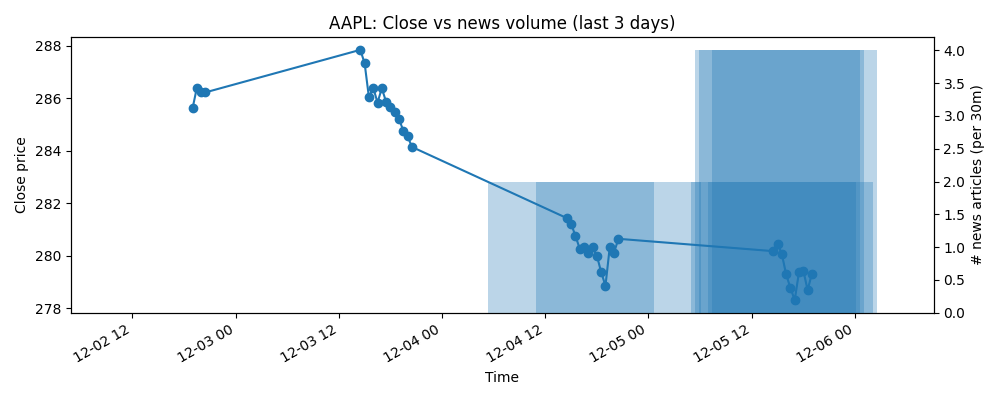

In [40]:
from IPython.display import Image, display
from pathlib import Path

chart_path = Path("/content/airflow/data/AAPL_price_news.png")
if chart_path.exists():
    display(Image(filename=str(chart_path)))
else:
    print("Chart not found yet. Make sure the DAG tasks have run at least once.")